In [62]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import pandas as pd
import  matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster

In [64]:
df = pd.read_csv('/content/drive/MyDrive/listings.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2265,Zen-East in the Heart of Austin (monthly rental),2466,Paddy,NaN,78702,30.27750,-97.71398,Entire home/apt,200,7,24,2019-03-16,0.17,3,131
1,5245,"Eco friendly, Colorful, Clean, Cozy monthly share",2466,Paddy,NaN,78702,30.27577,-97.71379,Private room,114,30,9,2018-03-14,0.06,3,0
2,5456,"Walk to 6th, Rainey St and Convention Ctr",8028,Sylvia,NaN,78702,30.26112,-97.73448,Entire home/apt,104,2,543,2021-02-01,3.74,1,354
3,5636,"Soco, Barton Springs Private Guest Cottage",7148,Peggy,NaN,78704,30.24630,-97.76361,Entire home/apt,46,30,21,2020-11-06,0.15,2,67
4,5769,NW Austin Room,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,39,1,259,2021-02-10,1.96,1,79


**1**

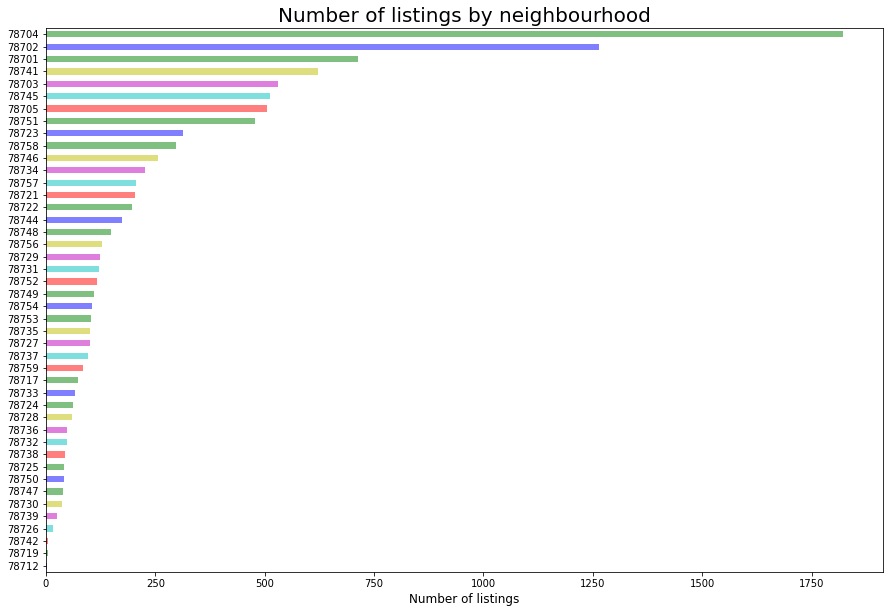

In [66]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']

feq=df['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(15, 10), color=  colors, alpha = .5,width=.5)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

In [ ]:
lats = df['latitude'].tolist()
lons = df['longitude'].tolist()
locations = list(zip(lats, lons))

map1 = folium.Map(location=[30.269501, -97.715942], zoom_start=10.4)
FastMarkerCluster(data=locations).add_to(map1)
map1.save("areas_with_highest_no._of_listings.html")
map1

===================================================================================================================


In [67]:
!pip install geopandas

**2** 

In [68]:
import geopandas as gpd
from branca.colormap import LinearColormap

In [69]:
feq = df[['neighbourhood',"room_type"]]
feq['room_type'] = feq['room_type'].apply(lambda x: x if x == 'Entire home/apt' else "single room")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
feq.head()

,neighbourhood,room_type
0,78702,Entire home/apt
1,78702,single room
2,78702,Entire home/apt
3,78704,Entire home/apt
4,78729,single room


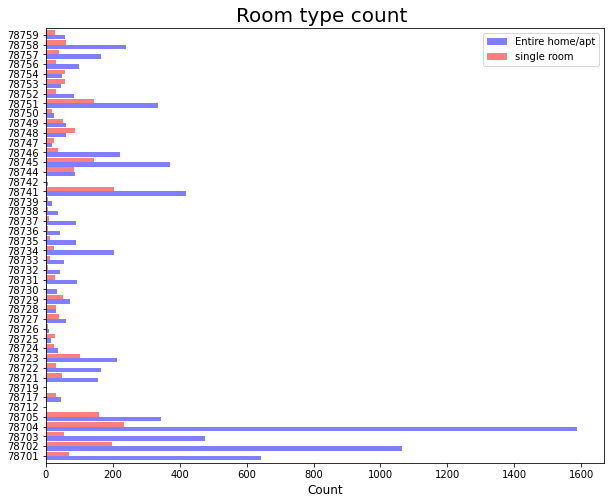

In [71]:
feq = feq.groupby(['neighbourhood',"room_type"])['room_type'].count() \
                  .unstack(fill_value=0)\
                  .rename_axis(None, axis=1)
feq.plot.barh(figsize=(10, 8), color=['b','r'], width=.9,alpha = .5)
plt.title('Room type count ', fontsize=20)
plt.xlabel('Count', fontsize=12)
plt.ylabel("")
plt.show()

In [72]:
feq['total'] = feq['Entire home/apt'] + feq['single room']

In [73]:
adam = gpd.read_file("/content/drive/MyDrive/neighbourhoods.geojson")
adam['neighbourhood']= adam['neighbourhood'].astype("int64")
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
map_dict = adam.set_index('neighbourhood')['total'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map2 = folium.Map(location=[30.269501, -97.715942], zoom_start=10.4)
folium.GeoJson(data=adam,
               name='Austin',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'Entire home/apt','single room'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map2)
map2.save("thematicmap_of_neighbourhood.html")
map2

===================================================================================================================


**3**

In [74]:
top_10 = df.groupby(['host_id'])['calculated_host_listings_count'].sum().sort_values(ascending = True)[-10:]
top_10[::-1]

host_id
359036978    128164
104309976     17161
109638288      6724
8167447        6561
118565935      3136
346827202      2304
194953121      2025
210733801      1849
368944610      1600
15782486       1444
Name: calculated_host_listings_count, dtype: int64

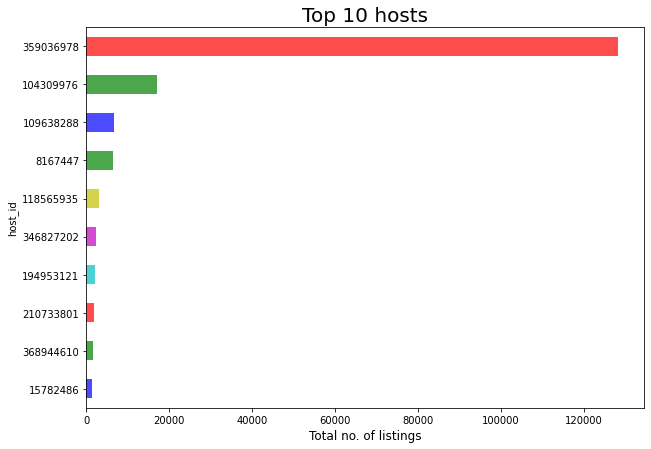

In [75]:
top_10.plot.barh(figsize=(10, 7), color= colors, alpha = .7,width=.5)
plt.title("Top 10 hosts", fontsize=20)
plt.xlabel('Total no. of listings', fontsize=12)
plt.show()

===================================================================================================================


**4**

In [ ]:
import seaborn as sns

In [76]:
df['price'] = df['price'].apply(lambda x:x[1:] if type(x)=="str" else x)

In [ ]:
df.info()

In [77]:
c = ['price', 'minimum_nights','number_of_reviews','calculated_host_listings_count', 'availability_365']

In [78]:
from sklearn.preprocessing import Normalizer
norm = pd.DataFrame(Normalizer().fit_transform(df[c]),columns=c) 

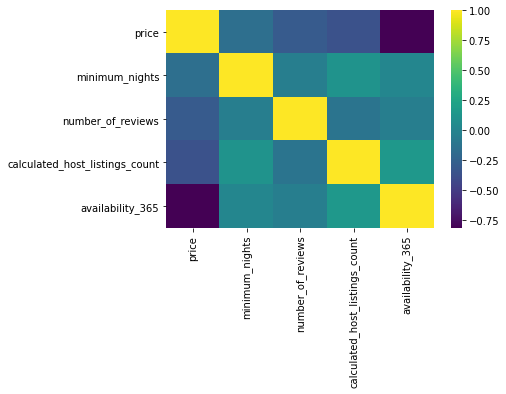

In [79]:
sns.heatmap(norm.corr(),cmap = 'viridis')

There is a strong negative correlation between price and availability_365( almost -0.75).
(i.e) Price increases with demand.

In [80]:
top_10_host_price = df.groupby(['host_id'])['price'].sum().sort_values(ascending = True)[-10:]

In [81]:
top_10_host_price[::-1]

host_id
210733801    154504
118565935     65558
359036978     41762
109638288     24135
104309976     21107
15864252      16418
152608759     16194
138398089     16130
15782486      13859
814883        12804
Name: price, dtype: int64

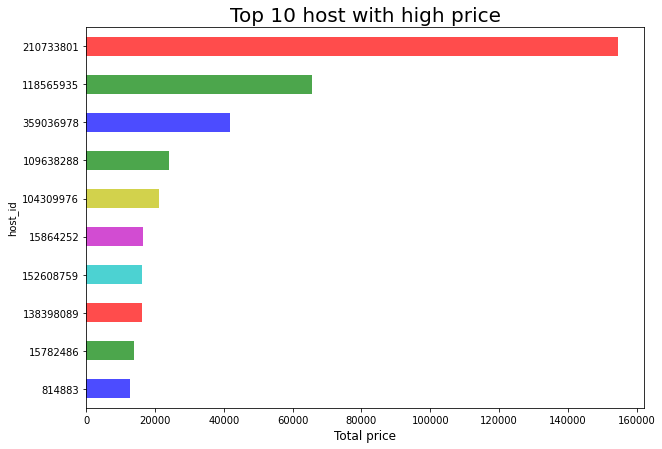

In [82]:
top_10_host_price.plot.barh(figsize=(10, 7), color= colors, alpha = .7,width=.5)
plt.title("Top 10 host with high price", fontsize=20)
plt.xlabel('Total price', fontsize=12)
plt.show()

In [84]:
negh_host = pd.DataFrame(df.groupby(['neighbourhood','host_id'])['host_id'].count().sort_values(ascending = True))[-10:]
negh_host.columns = ['host_count']

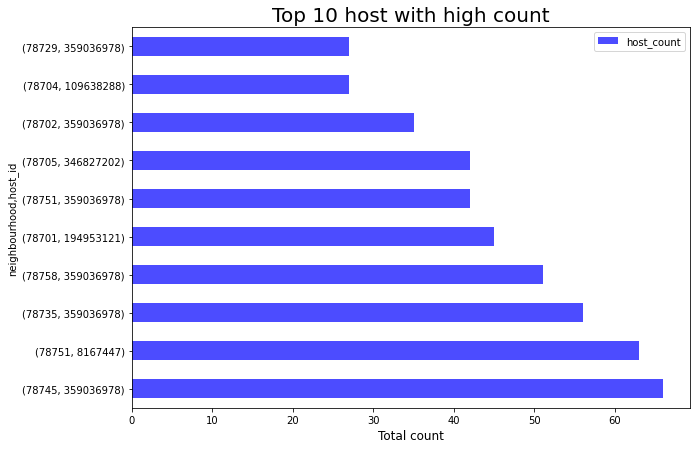

In [83]:
negh_host[::-1].plot.barh(figsize=(10, 7), color= colors, alpha = .7,width=.5)
plt.title("Top 10 host with high count", fontsize=20)
plt.xlabel('Total count', fontsize=12)
plt.show()